## Dependencias

In [1]:
import numpy as np
import pandas as pd 

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS,TSNE
from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score


from scipy.stats import kruskal
from statsmodels.stats.multicomp import MultiComparison

from itertools import chain
from functools import reduce

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly.express as px
import plotly.graph_objects as go

cf.go_offline()
pd.set_option('display.max_columns',None)

In [2]:
df = sns.load_dataset('mpg') #dataset de autos

In [3]:
df['model_year'].value_counts().sort_index()

70    29
71    28
72    28
73    40
74    27
75    30
76    34
77    28
78    36
79    29
80    29
81    29
82    31
Name: model_year, dtype: int64

In [4]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [5]:
df.shape #conjunto pequeñp

(398, 9)

In [6]:
df['brand'] = df['name'].map(lambda x:x.split(' ')[0]) 

In [7]:

df['cylinders'] = df['cylinders'].astype(int) #pasanos a enteros los cilindros

In [8]:
#separamos continuas y discretas
varc = ['mpg','displacement','horsepower','weight','acceleration']
vard = ['cylinders','brand','origin']

In [9]:
#Normalizamos las categorias pequeñas a otros
def normalizar(df,v,umbral=0.05):
    aux = df[v].value_counts(1).to_frame().reset_index()
    aux['mapa'] = np.where(aux[v]<umbral,'OTROS',aux['index'])
    mas_grande = aux.head(1)['index'].values[0]
    if aux.loc[aux['mapa']=='OTROS'][v].sum()<umbral:
        aux['mapa'] = aux['mapa'].replace({'OTROS':mas_grande})
        if v=='cylinders':
            aux['mapa']=aux['mapa'].astype(int)
    return v,dict(aux[['index','mapa']].values.tolist())

In [10]:
mapa_norm = list(map(lambda v:normalizar(df,v),vard))

In [11]:
mapa_norm

[('cylinders', {4: 4, 8: 8, 6: 6, 3: 4, 5: 4}),
 ('brand',
  {'ford': 'ford',
   'chevrolet': 'chevrolet',
   'plymouth': 'plymouth',
   'dodge': 'dodge',
   'amc': 'amc',
   'toyota': 'toyota',
   'datsun': 'datsun',
   'buick': 'OTROS',
   'pontiac': 'OTROS',
   'volkswagen': 'OTROS',
   'honda': 'OTROS',
   'mercury': 'OTROS',
   'oldsmobile': 'OTROS',
   'mazda': 'OTROS',
   'peugeot': 'OTROS',
   'fiat': 'OTROS',
   'audi': 'OTROS',
   'chrysler': 'OTROS',
   'vw': 'OTROS',
   'volvo': 'OTROS',
   'renault': 'OTROS',
   'opel': 'OTROS',
   'subaru': 'OTROS',
   'saab': 'OTROS',
   'chevy': 'OTROS',
   'bmw': 'OTROS',
   'cadillac': 'OTROS',
   'mercedes-benz': 'OTROS',
   'maxda': 'OTROS',
   'mercedes': 'OTROS',
   'chevroelt': 'OTROS',
   'triumph': 'OTROS',
   'nissan': 'OTROS',
   'toyouta': 'OTROS',
   'capri': 'OTROS',
   'vokswagen': 'OTROS',
   'hi': 'OTROS'}),
 ('origin', {'usa': 'usa', 'japan': 'japan', 'europe': 'europe'})]

In [12]:
for v,d in mapa_norm:
    df[f'n_{v}'] = df[v].replace(d)

In [13]:
varn = df.filter(like='n_').columns.tolist()

In [14]:
for v in varn:
    print(v,end='\n')
    print(df[v].value_counts(1),end='\n'*2)
#Vemos como se comportan aca pasa que otros es muy alto y no deberia de pasar

n_cylinders
4    0.530151
8    0.258794
6    0.211055
Name: n_cylinders, dtype: float64

n_brand
OTROS        0.424623
ford         0.128141
chevrolet    0.108040
plymouth     0.077889
dodge        0.070352
amc          0.070352
toyota       0.062814
datsun       0.057789
Name: n_brand, dtype: float64

n_origin
usa       0.625628
japan     0.198492
europe    0.175879
Name: n_origin, dtype: float64



In [15]:
df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
name            0
brand           0
n_cylinders     0
n_brand         0
n_origin        0
dtype: int64

In [16]:
df = df.dropna().reset_index(drop=True)

array([[<AxesSubplot:title={'center':'mpg'}>,
        <AxesSubplot:title={'center':'displacement'}>],
       [<AxesSubplot:title={'center':'horsepower'}>,
        <AxesSubplot:title={'center':'weight'}>],
       [<AxesSubplot:title={'center':'acceleration'}>, <AxesSubplot:>]],
      dtype=object)

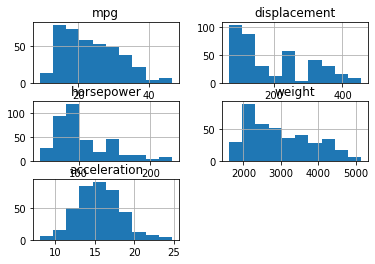

In [17]:
df[varc].hist()

In [18]:
len(varc)

5

In [19]:
X = df[varc].copy() #peramos las variables continuas que son con las que
#vamos a clusterizar

### PCA $\mathcal{X}\to\mathcal{X}_p$

In [20]:
sc = StandardScaler()
pca = PCA(n_components=3)
Xp = pd.DataFrame(pca.fit_transform(sc.fit_transform(X)))
print(pca.explained_variance_ratio_.cumsum())
Xp
#pca se usa igual para modelar

[0.78535088 0.927752   0.97287636]


,0,1,2
0,1.875970,-0.648558,-0.052615
1,2.852657,-0.675575,0.005838
2,2.262764,-1.043147,0.015094
3,2.188684,-0.666426,-0.196684
4,2.187813,-1.146458,-0.225587
...,...,...,...
387,-0.798233,-0.202521,0.025992
388,-3.856022,1.797054,1.772717
389,-0.919813,-1.859696,0.140565
390,-1.492570,0.645762,0.128738


### MDS $\mathcal{X}\to\mathcal{X}_m$

In [21]:
sc = MinMaxScaler()
mds = MDS(n_components=3,n_jobs=-1)
Xm = pd.DataFrame(mds.fit_transform(sc.fit_transform(X)))
Xm
#mds a tre componentes

,0,1,2
0,-0.174514,0.357781,-0.166850
1,-0.228999,0.559089,-0.233973
2,-0.207377,0.406874,-0.255266
3,-0.150336,0.420036,-0.203514
4,-0.156287,0.394126,-0.263044
...,...,...,...
387,0.045285,-0.187716,-0.007133
388,-0.029191,-0.772036,0.450094
389,0.027640,-0.316539,-0.281998
390,0.087126,-0.287074,0.151595


### t-SNE $\mathcal{X}\to\mathcal{X}_t$

In [22]:
sc = MinMaxScaler()
tsne = TSNE(n_components=3,n_jobs=-1,perplexity=15)
Xt = pd.DataFrame(tsne.fit_transform(sc.fit_transform(X)))
Xt
#tsne en 3d

,0,1,2
0,53.141579,68.143341,6.698697
1,42.980789,27.633577,27.235247
2,49.140625,43.053871,2.248292
3,46.111504,54.223930,8.879415
4,57.591202,52.788040,1.063910
...,...,...,...
387,-9.331744,-8.919601,-26.185667
388,27.541433,-40.392643,65.847046
389,-0.553454,-76.759491,6.176832
390,15.125755,-34.629520,-2.534567


In [23]:
Xp.iplot(kind='scatter3d',x=0,y=1,z=2,mode='markers',color='red')

In [24]:
Xm.iplot(kind='scatter3d',x=0,y=1,z=2,mode='markers',color='red')

In [25]:
Xt.iplot(kind='scatter3d',x=0,y=1,z=2,mode='markers',color='red')

In [26]:
sc = MinMaxScaler()
Xs = pd.DataFrame(sc.fit_transform(X),columns=varc) #guardamos lo datos ya escalados

### Agglomerativo

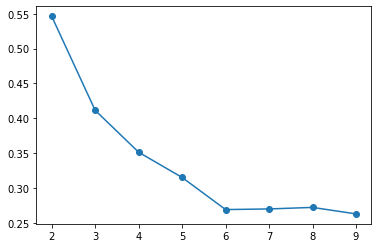

In [27]:
sil = pd.DataFrame(map(lambda k:(k,silhouette_score(Xs,
                                              AgglomerativeClustering(n_clusters=k).fit_predict(Xs))),
                 range(2,10)),columns=['k','sil'])
plt.plot(sil['k'],sil['sil'],marker='o')
# 2 o 3 es lo mejor

In [28]:
k = 3 #tomamos el segundo menor
tipo = 'agg'
agg = AgglomerativeClustering(n_clusters=k)
df[f'cl_{tipo}']=Xp[f'cl_{tipo}']=Xm[f'cl_{tipo}']=Xt[f'cl_{tipo}'] =agg.fit_predict(Xs[varc])

### K-Medias

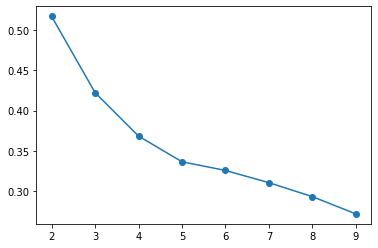

In [29]:
sil = pd.DataFrame(map(lambda k:(k,silhouette_score(Xs,
                                              KMeans(n_clusters=k,max_iter=1000).fit_predict(Xs))),
                 range(2,10)),columns=['k','sil'])
plt.plot(sil['k'],sil['sil'],marker='o')

In [30]:
k = 3
tipo = 'kme'
kme = KMeans(n_clusters=k,max_iter=1000)
df[f'cl_{tipo}']=Xp[f'cl_{tipo}']=Xm[f'cl_{tipo}']=Xt[f'cl_{tipo}'] =kme.fit_predict(Xs[varc])

### Modelos Gaussianos Mixtos

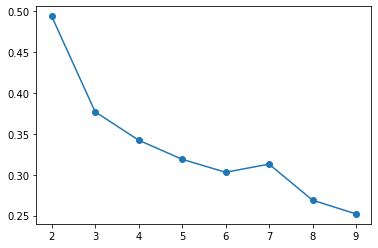

In [31]:
sil = pd.DataFrame(map(lambda k:(k,silhouette_score(Xs,
                                              GaussianMixture(n_components=k,max_iter=1000).fit_predict(Xs))),
                 range(2,10)),columns=['k','sil'])
plt.plot(sil['k'],sil['sil'],marker='o')

In [32]:
k = 3
tipo = 'gmm'
gmm = GaussianMixture(n_components=k,max_iter=1000)
df[f'cl_{tipo}']=Xp[f'cl_{tipo}']=Xm[f'cl_{tipo}']=Xt[f'cl_{tipo}'] =gmm.fit_predict(Xs[varc])

In [33]:
varcl = sorted(df.filter(like='cl_'))
for v in varcl:
    Xp[v] = Xp[v].astype(str)
    Xm[v] = Xm[v].astype(str)
    Xt[v] = Xt[v].astype(str)
    df[v] = df[v].astype(str)
 #silueta mas grande por cada metodo   
pd.DataFrame(map(lambda cl:(cl,silhouette_score(Xs,df[cl])),varcl),columns=['cluster','sil']).iplot(kind='bar',categories='cluster')

<AxesSubplot:xlabel='0', ylabel='1'>

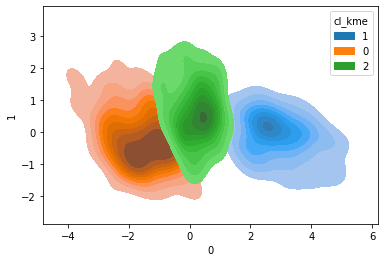

In [34]:
Xp.iplot(kind='scatter3d',x=0,y=1,z=2,mode='markers',categories='cl_kme')
sns.kdeplot(data=Xp,x=0,y=1,fill=True,hue='cl_kme')
#distribucion

<AxesSubplot:xlabel='0', ylabel='1'>

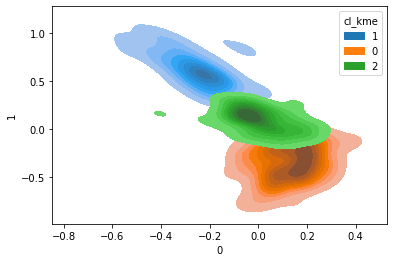

In [35]:
Xm.iplot(kind='scatter3d',x=0,y=1,z=2,mode='markers',categories='cl_kme')
sns.kdeplot(data=Xm,x=0,y=1,fill=True,hue='cl_kme')

<AxesSubplot:xlabel='0', ylabel='1'>

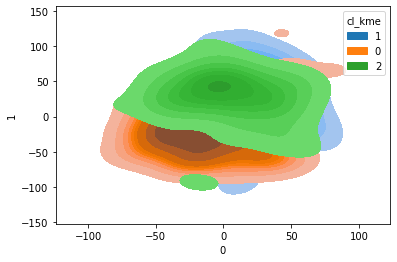

In [36]:
Xt.iplot(kind='scatter3d',x=0,y=1,z=2,mode='markers',categories='cl_kme')
sns.kdeplot(data=Xt,x=0,y=1,fill=True,hue='cl_kme')

In [37]:
v = varc[0]
pd.DataFrame(map(lambda v:(v,
              kruskal(*[d[v].reset_index(drop=True) for cl,d in df[['cl_kme',v]].groupby('cl_kme')]).pvalue),varc),
             columns=['variable','p-value']).round(2)
#Vemos la prueba de kruskal

,variable,p-value
0,mpg,0.0
1,displacement,0.0
2,horsepower,0.0
3,weight,0.0
4,acceleration,0.0


mpg


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-15.0689,0.001,-16.3253,-13.8125,True
0,2,-9.8842,0.001,-11.1406,-8.6278,True
1,2,5.1847,0.001,3.734,6.6354,True


displacement


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,238.9005,0.001,228.305,249.4961,True
0,2,102.1862,0.001,91.5907,112.7818,True
1,2,-136.7143,0.001,-148.949,-124.4796,True


horsepower


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,83.4898,0.001,78.337,88.6426,True
0,2,22.6327,0.001,17.4798,27.7855,True
1,2,-60.8571,0.001,-66.8071,-54.9071,True


weight


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,1857.5867,0.001,1753.0885,1962.085,True
0,2,917.1786,0.001,812.6803,1021.6768,True
1,2,-940.4082,0.001,-1061.0723,-819.744,True


acceleration


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-3.7724,0.001,-4.418,-3.1269,True
0,2,0.0888,0.9,-0.5567,0.7343,False
1,2,3.8612,0.001,3.1158,4.6066,True


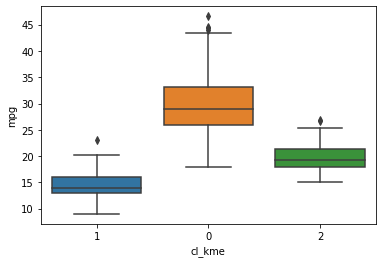

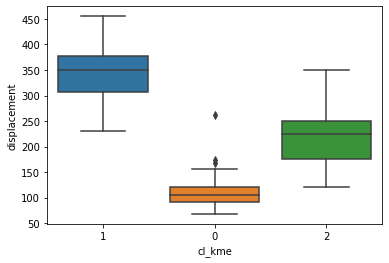

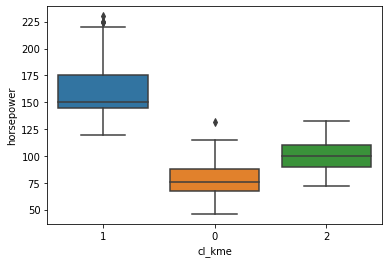

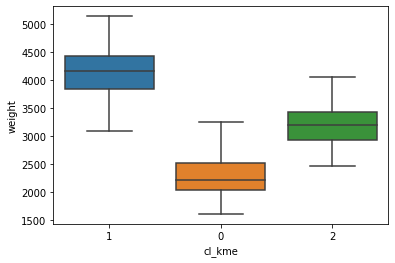

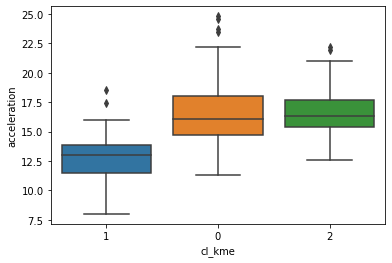

In [38]:
for v in varc:
    print(v)
    display(MultiComparison(df[v],df['cl_kme']).tukeyhsd().summary())
    plt.figure()
    sns.boxplot(data=df,y=v,x='cl_kme')
#Vemos cuales son diferentes con tukey, con boxplot ilustramos el perfilamiento hecho

In [39]:
display(df[varc+['cl_kme']].groupby('cl_kme').mean().style.background_gradient(axis=0))
display(df[varc].mean().to_frame().T)
#comparacion grupos contra la media general

,mpg,displacement,horsepower,weight,acceleration
cl_kme,,,,,
0,29.684184,109.140306,77.938776,2283.892857,16.462245
1,14.615306,348.040816,161.428571,4141.479592,12.689796
2,19.800000,211.326531,100.571429,3201.071429,16.551020


,mpg,displacement,horsepower,weight,acceleration
0,23.445918,194.41199,104.469388,2977.584184,15.541327


0---> Economicos/compactos
1---> Todo terreno
2---> sedan/amplios

In [40]:
df['cl_kme'].value_counts(1) #Checamos proporciones

0    0.50
2    0.25
1    0.25
Name: cl_kme, dtype: float64

In [41]:
df.loc[df.cl_kme=='0'].sample(10)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,brand,n_cylinders,n_brand,n_origin,cl_agg,cl_kme,cl_gmm
341,35.1,4,81.0,60.0,1760,16.1,81,japan,honda civic 1300,honda,4,OTROS,japan,0,0,0
387,27.0,4,140.0,86.0,2790,15.6,82,usa,ford mustang gl,ford,4,ford,usa,0,0,0
354,28.1,4,141.0,80.0,3230,20.4,81,europe,peugeot 505s turbo diesel,peugeot,4,OTROS,europe,0,0,2
169,24.0,4,134.0,96.0,2702,13.5,75,japan,toyota corona,toyota,4,toyota,japan,0,0,0
362,28.0,4,112.0,88.0,2605,19.6,82,usa,chevrolet cavalier,chevrolet,4,chevrolet,usa,0,0,0
348,29.9,4,98.0,65.0,2380,20.7,81,usa,ford escort 2h,ford,4,ford,usa,0,0,0
340,39.0,4,86.0,64.0,1875,16.4,81,usa,plymouth champ,plymouth,4,plymouth,usa,0,0,0
385,36.0,4,135.0,84.0,2370,13.0,82,usa,dodge charger 2.2,dodge,4,dodge,usa,0,0,0
318,37.0,4,119.0,92.0,2434,15.0,80,japan,datsun 510 hatchback,datsun,4,datsun,japan,0,0,0
294,27.4,4,121.0,80.0,2670,15.0,79,usa,amc spirit dl,amc,4,amc,usa,0,0,0


In [42]:
Xs['cl_kme'] = df['cl_kme']

In [43]:
aux = Xs[varc+['cl_kme']].groupby('cl_kme').mean()
aux Datos escalados

,mpg,displacement,horsepower,weight,acceleration
cl_kme,,,,,
0,0.550111,0.106306,0.173580,0.190216,0.503705
1,0.149343,0.723620,0.627329,0.716892,0.279155
2,0.287234,0.370353,0.296584,0.450261,0.508989


In [44]:
fig = go.Figure()
#radar
for i,row in aux.iterrows():
    fig.add_trace(go.Scatterpolar(r=row.values,
                                  theta=varc,
                                  fill='toself',
                                  name=f'cluster {i}'))
fig.show()

In [71]:
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,brand,n_cylinders,n_brand,n_origin,cl_agg,cl_kme,cl_gmm,aux
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu,chevrolet,8,chevrolet,usa,1,2,1,1
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320,buick,8,OTROS,usa,1,2,1,1
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite,plymouth,8,plymouth,usa,1,2,1,1
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst,amc,8,amc,usa,1,2,1,1
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino,ford,8,ford,usa,1,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86.0,2790,15.6,82,usa,ford mustang gl,ford,4,ford,usa,0,1,0,1
388,44.0,4,97.0,52.0,2130,24.6,82,europe,vw pickup,vw,4,OTROS,europe,0,1,0,1
389,32.0,4,135.0,84.0,2295,11.6,82,usa,dodge rampage,dodge,4,dodge,usa,0,1,0,1
390,28.0,4,120.0,79.0,2625,18.6,82,usa,ford ranger,ford,4,ford,usa,0,1,0,1


In [45]:
df['aux']=1

In [46]:
auxtotal=df.groupby('model_year').agg({'aux':'sum'})['aux'] #agrupacion por año

In [47]:
piv=df.pivot_table(index='model_year',columns='cl_kme',values='aux',aggfunc='sum')
piv #Autos por año

cl_kme,0,1,2
model_year,,,
70,7.0,18.0,4.0
71,12.0,7.0,8.0
72,13.0,13.0,2.0
73,11.0,20.0,9.0
74,15.0,5.0,6.0
75,11.0,5.0,14.0
76,13.0,9.0,12.0
77,15.0,7.0,6.0
78,14.0,6.0,16.0


In [48]:
for i in piv.columns:
    piv[i]=piv[i]/auxtotal

In [65]:
piv

cl_kme,0,1,2
70,0.241379,0.620690,0.137931
71,0.444444,0.259259,0.296296
72,0.464286,0.464286,0.071429
73,0.275000,0.500000,0.225000
74,0.576923,0.192308,0.230769
75,0.366667,0.166667,0.466667
76,0.382353,0.264706,0.352941
77,0.535714,0.250000,0.214286
78,0.388889,0.166667,0.444444
79,0.413793,0.275862,0.310345


In [49]:
piv.iplot(kind='bar',barmode='stack') #No se ve estable

In [50]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,brand,n_cylinders,n_brand,n_origin,cl_agg,cl_kme,cl_gmm,aux
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu,chevrolet,8,chevrolet,usa,1,1,1,1
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320,buick,8,OTROS,usa,1,1,1,1
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite,plymouth,8,plymouth,usa,1,1,1,1
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst,amc,8,amc,usa,1,1,1,1
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino,ford,8,ford,usa,1,1,1,1


In [51]:
piv

cl_kme,0,1,2
model_year,,,
70,0.241379,0.620690,0.137931
71,0.444444,0.259259,0.296296
72,0.464286,0.464286,0.071429
73,0.275000,0.500000,0.225000
74,0.576923,0.192308,0.230769
75,0.366667,0.166667,0.466667
76,0.382353,0.264706,0.352941
77,0.535714,0.250000,0.214286
78,0.388889,0.166667,0.444444


In [52]:
esperado=pd.DataFrame(df.groupby('cl_kme').agg({'aux':'sum'})['aux']/df['aux'].sum()).T
esperado
#PSI comparamos esperados

cl_kme,0,1,2
aux,0.5,0.25,0.25


In [53]:
esperado.index=['E']

In [66]:
esperado

cl_kme,0,1,2
E,0.5,0.25,0.25


In [54]:
piv=pd.concat([piv,esperado],axis=0)
piv #concatenamos los valores esperados

cl_kme,0,1,2
70,0.241379,0.620690,0.137931
71,0.444444,0.259259,0.296296
72,0.464286,0.464286,0.071429
73,0.275000,0.500000,0.225000
74,0.576923,0.192308,0.230769
75,0.366667,0.166667,0.466667
76,0.382353,0.264706,0.352941
77,0.535714,0.250000,0.214286
78,0.388889,0.166667,0.444444
79,0.413793,0.275862,0.310345


In [55]:
piv.index=piv.index.astype(str)

In [56]:
piv.iplot(kind='bar',barmode='stack')

In [57]:
piv.fillna(0,inplace=True)

In [58]:
psi=pd.DataFrame()
for i in piv.columns:
    psi[i]=(piv[i]-esperado[i].iloc[0])*np.log(piv[i]/esperado[i].iloc[0])
psi
#calculamos el psi

/home/jorge/Documents/Diplomado/ambientes/diplo_env/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning:

divide by zero encountered in log



,0,1,2
70,0.188338,0.337094,0.066648
71,0.006544,0.000337,0.007866
72,0.002647,0.132651,0.223708
73,0.134513,0.173287,0.002634
74,0.011008,0.015136,0.001539
75,0.041354,0.033789,0.135233
76,0.031560,0.000841,0.035498
77,0.002464,0.000000,0.005505
78,0.027924,0.033789,0.111876
79,0.016314,0.002546,0.013048


In [59]:
df_psi=pd.DataFrame(psi.sum(axis=1),columns=['psi'])
df_psi

,psi
70,0.592080
71,0.014746
72,0.359006
73,0.310434
74,0.027683
75,0.210376
76,0.067899
77,0.007969
78,0.173589
79,0.031908


In [60]:
piv

cl_kme,0,1,2
70,0.241379,0.620690,0.137931
71,0.444444,0.259259,0.296296
72,0.464286,0.464286,0.071429
73,0.275000,0.500000,0.225000
74,0.576923,0.192308,0.230769
75,0.366667,0.166667,0.466667
76,0.382353,0.264706,0.352941
77,0.535714,0.250000,0.214286
78,0.388889,0.166667,0.444444
79,0.413793,0.275862,0.310345


In [61]:
df_psi['lim_inf']=.1 #definimos treshots
df_psi['lim_sup']=.25

In [62]:
df_psi.iplot() #hay cambios significativos

In [63]:
df_psi.index=df_psi.index.astype(str)

In [64]:
df_psi.replace(np.inf,1).iplot()

In [67]:
df_psi

,psi,lim_inf,lim_sup
70,0.592080,0.1,0.25
71,0.014746,0.1,0.25
72,0.359006,0.1,0.25
73,0.310434,0.1,0.25
74,0.027683,0.1,0.25
75,0.210376,0.1,0.25
76,0.067899,0.1,0.25
77,0.007969,0.1,0.25
78,0.173589,0.1,0.25
79,0.031908,0.1,0.25


Una solucion seria hacer un cambio de clusters, podriamos intentar con 4